In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [ ]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_melspecs_flattened_base_100.feather"
df_base = pd.read_feather(filepath)

In [ ]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np


# get features
FEATURES = [c for c in df_base.columns if c.startswith('melspec_')]
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


X_train: (800, 65568)
X_test:  (200, 65568)


## Experiment \#1: GMM with 1 component

not feasible due to the number of features

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# for each class, fit a GM to get the pdf
gms = []

for y_value in np.unique(y_train):
  mask = (y_train == y_value)
  gm = GaussianMixture(n_components=1, random_state=10)
  gm.fit(X_train[mask, :])
  gms.append(gm)

# generate log likelihood for train and test sets using each GM
y_train_log_likelihoods = []
y_test_log_likelihoods = []

for gm in gms:
  y_train_log_likelihoods.append(gm.score_samples(X_train))
  y_test_log_likelihoods.append(gm.score_samples(X_test))

y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(F"Train accuracy: {train_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

## Experiment \#2: GMM with 1 component and feature selection via select k best

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10,2010,10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  # feature selection via select k best
  mask_selected_features = np.full((X_train.shape[1], ), False)

  for y_value in np.unique(y_train):
    skb = SelectKBest(k=top_n)
    mask = y_train == y_value
    skb.fit(X_train[mask, :], y_train[mask])
    mask_selected_features |= skb.get_support()

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=3, random_state=10)
    gm.fit(X_train[mask, :][:, mask_selected_features])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, mask_selected_features]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, mask_selected_features]))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with feature selection via select k best (k={top_n})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

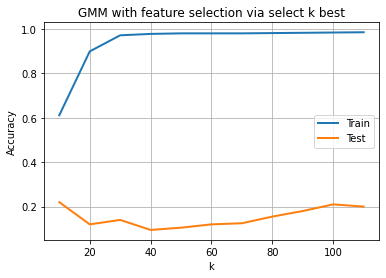

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with feature selection via select k best")
ax.set_xlabel("k")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#3: GMM with feature selection via random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=500, 
                             random_state=10)
clf.fit(X_train, y_train)
df_feature_importance = pd.DataFrame({"feature_name": FEATURES, 
                                      "feature_importance": clf.feature_importances_})
df_feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10, 2010, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  top_features = df_feature_importance.head(top_n)['feature_name'].unique()
  feature_indices = [FEATURES.index(f) for f in top_features]

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=1, random_state=10)
    gm.fit(X_train[mask, :][:, feature_indices])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, feature_indices]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, feature_indices]))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with feature selection via random forest (k={top_n})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with feature selection via random forest (k=10)...
Train accuracy: 0.365
Test accuracy:  0.28
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=20)...
Train accuracy: 0.62125
Test accuracy:  0.265
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=30)...
Train accuracy: 0.8175
Test accuracy:  0.2
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=40)...
Train accuracy: 0.94125
Test accuracy:  0.205
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=50)...
Train accu

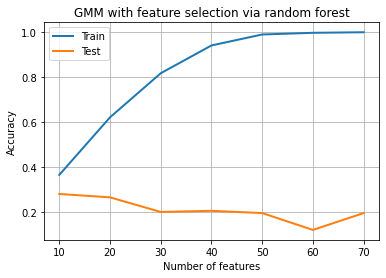

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with feature selection via random forest")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#4: GMM with PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

tolerance = 10
n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:
  
  # get pca
  pca = PCA(n_components)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=1, random_state=10)
    gm.fit(X_train_pca[mask, :])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train_pca))
    y_test_log_likelihoods.append(gm.score_samples(X_test_pca))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with dimensionality reduction via PCA (n_components={n_components})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with dimensionality reduction via PCA (n_components=10)...
Train accuracy: 0.36625
Test accuracy:  0.29
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reduction via PCA (n_components=20)...
Train accuracy: 0.60875
Test accuracy:  0.275
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reduction via PCA (n_components=30)...
Train accuracy: 0.7725
Test accuracy:  0.235
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reduction via PCA (n_components=40)...
Train accuracy: 0.8925
Test accuracy:  0.29
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reducti

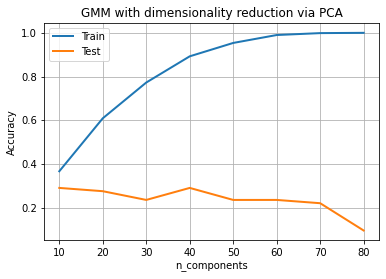

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with dimensionality reduction via PCA")
ax.set_xlabel("n_components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#5: Logistic regression with kernal PCA

In [ ]:
"""
Use kernel PCA to perform dimensionality reduction
"""
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

tolerance = 10
n_components_list = np.arange(50, 2050, 50)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  kpca = KernelPCA(n_components=n_components, 
                   kernel='rbf', 
                   n_jobs=-1, 
                   random_state=10,
                   eigen_solver="randomized")
  X_train_kpca = kpca.fit_transform(X_train)
  X_test_kpca = kpca.transform(X_test)

  clf = LogisticRegression(max_iter=10000, class_weight='balanced')
  clf.fit(X_train_kpca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_kpca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_kpca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from kernel PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Using 50 components from kernel PCA...
Train accuracy: 0.40875
Test accuracy:  0.34
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 100 components from kernel PCA...
Train accuracy: 0.44875
Test accuracy:  0.345
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 150 components from kernel PCA...
Train accuracy: 0.48625
Test accuracy:  0.34
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 200 components from kernel PCA...
Train accuracy: 0.51625
Test accuracy:  0.33
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 250 components from kernel PCA...
Train accuracy: 0.5625
Test accuracy:  0.325
Overfitting detected!
-------------------------------------------------------------

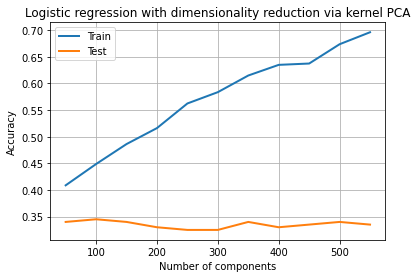

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("Logistic regression with dimensionality reduction via kernel PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()